<a href="https://colab.research.google.com/github/rcelebi/iswc2020-smarttask/blob/master/Fast_AI_type_pred_dbpedia_high_level_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install fastai==1.0.61

In [2]:
from fastai.text import *
#from fastai.text.all import *

In [3]:
bs=64

## Data

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import os
path_to_ipynb = '/content/drive/My Drive/iswc-ammar/shervin'
# change directory to where autoregq.py, src, and data are
os.chdir(path_to_ipynb)

In [15]:
import pandas as pd
import numpy as np


In [16]:
dbpedia_df = pd.read_json('data/smarttask_dbpedia_train.json')
test_df= pd.read_json('data/smarttask_dbpedia_test.json')

In [17]:
test_df.head()

,id,question,category,type
0,dbpedia_16015,How many ingredients are in the grain} ?,literal,[number]
1,dbpedia_3885,Is the case fatality rate of Fournier gangrene...,boolean,[boolean]
2,dbpedia_12907,Does the shelf life of spinach equal 8?,boolean,[boolean]
3,dbpedia_7955,What sound does a pig make in the French langu...,literal,[string]
4,dbpedia_2376,When was Fergie completed his record label in ...,literal,[date]


In [18]:
answer_types = {}
for answers in dbpedia_df.type:
    for a in answers:
        if a in answer_types:
            answer_types[a]+=1
        else:
            answer_types[a]=1

def multitype_to_freqtype(type_list):
    for t in sorted(sorted_types, key=lambda item: item[1]):
        if sorted_types[t] < 1000: 
          if t in type_list:
              return t

    for t in sorted(sorted_types, key=lambda item: item[1]):
          if t in type_list:
              return t
    

def types_to_bottom_type(type_list):
    if len(type_list) == 0:
      return None 
    return type_list[0]


def types_to_top_type(type_list):
    if len(type_list) == 0:
      return None 
    return type_list[-1]
            
answ_df =pd.DataFrame.from_dict(answer_types, orient='index', columns=['Freq'])
sorted_types = answ_df.sort_values(by='Freq', ascending=False).to_dict()['Freq']

dbpedia_df['frequent_type'] =dbpedia_df.type.apply(multitype_to_freqtype)
dbpedia_df['bottom_level_type'] =dbpedia_df.type.apply(types_to_bottom_type)
dbpedia_df['top_level_type'] =dbpedia_df.type.apply(types_to_top_type)

In [19]:
test_df['frequent_type'] =test_df.type.apply(multitype_to_freqtype)
test_df['bottom_level_type'] =test_df.type.apply(types_to_bottom_type)
test_df['top_level_type'] =test_df.type.apply(types_to_top_type)

In [20]:
dbpedia_df= dbpedia_df[dbpedia_df.category.notna()]
test_df= test_df[test_df.category.notna()]

In [21]:
dbpedia_df= dbpedia_df[dbpedia_df['frequent_type'].notna()]
test_df= test_df[test_df['frequent_type'].notna()]

In [22]:
dbpedia_df.dropna( subset=['question'], inplace=True)
test_df.dropna( subset=['question'], inplace=True)

In [23]:
dbpedia_df.head()

,id,question,category,type,frequent_type,bottom_level_type,top_level_type
0,dbpedia_1177,Was Jacqueline Kennedy Onassis a follower of M...,boolean,[boolean],boolean,boolean,boolean
1,dbpedia_14427,What is the name of the opera based on Twelfth...,resource,"[dbo:Opera, dbo:MusicalWork, dbo:Work]",dbo:Work,dbo:Opera,dbo:Work
2,dbpedia_16615,When did Lena Horne receive the Grammy Award f...,literal,[date],date,date,date
3,dbpedia_23480,Do Prince Harry and Prince William have the sa...,boolean,[boolean],boolean,boolean,boolean
4,dbpedia_3681,What is the subsidiary company working for Leo...,resource,"[dbo:EducationalInstitution, dbo:Organisation,...",dbo:EducationalInstitution,dbo:EducationalInstitution,dbo:Agent


In [24]:
def extend_cat(row):
  if row['category'] =='boolean':
    return row['category']
  elif row['category'] == 'literal':
    return row['frequent_type']
  else:
    return row['category']


In [25]:
dbpedia_df['extended_cat'] = dbpedia_df.apply(extend_cat, axis=1)

In [26]:
VALIDATION_SPLIT = 0.2
indicies = np.arange(dbpedia_df.shape[0])
np.random.shuffle(indicies)
num_valid_samples = int(VALIDATION_SPLIT * dbpedia_df.shape[0])
num_valid_samples

3502

In [27]:
num_test_samples=  int(num_valid_samples/2)

In [28]:
dbpedia_df=dbpedia_df.iloc[indicies]

In [29]:
train_df= dbpedia_df[:-num_valid_samples]
train_df.head()

,id,question,category,type,frequent_type,bottom_level_type,top_level_type,extended_cat
10349,dbpedia_1919,Who received Steiger Award together with Wladi...,resource,"[dbo:Person, dbo:Agent]",dbo:Agent,dbo:Person,dbo:Agent,resource
4931,dbpedia_18703,Which river originates from Cape Vincent and K...,resource,"[dbo:River, dbo:Stream, dbo:BodyOfWater, dbo:N...",dbo:NaturalPlace,dbo:River,dbo:Location,resource
15996,dbpedia_2663,How many creators are with the Pokémon?,literal,[number],number,number,number,number
15866,dbpedia_5579,What is the Filmweb.pl film ID of Mr. Smith go...,literal,[string],string,string,string,string
15432,dbpedia_20916,Who is the office holder for constituencies C...,resource,"[dbo:OfficeHolder, dbo:Person, dbo:Agent]",dbo:OfficeHolder,dbo:OfficeHolder,dbo:Agent,resource


In [30]:
valid_df= dbpedia_df[-num_valid_samples:]
valid_df.head()

,id,question,category,type,frequent_type,bottom_level_type,top_level_type,extended_cat
8121,dbpedia_11151,Tell me religious behaviour whose name has the...,resource,[dbo:Activity],dbo:Activity,dbo:Activity,dbo:Activity,resource
6353,dbpedia_4311,what party does mauricio marci like,resource,"[dbo:PoliticalParty, dbo:Organisation, dbo:Agent]",dbo:PoliticalParty,dbo:PoliticalParty,dbo:Agent,resource
3307,dbpedia_20116,Which party of Rishang Keishing is the leader ...,resource,[dbo:PoliticalParty],dbo:PoliticalParty,dbo:PoliticalParty,dbo:PoliticalParty,resource
264,dbpedia_19932,Which school of jack mcGregor attend which was...,resource,"[dbo:University, dbo:EducationalInstitution, d...",dbo:EducationalInstitution,dbo:University,dbo:Agent,resource
12897,dbpedia_2616,What is Moscow State University's elibrary.ru ...,literal,[string],string,string,string,string


In [31]:
len(valid_df)

3502

In [32]:
valid_df.to_csv('/content/drive/My Drive/fastai-v3/data/smarttask/dbpedia_valid_gold.csv', index=False)

In [33]:
#test_df= dbpedia_df[-num_test_samples:]
#test_df.head()

In [34]:
len(valid_df)

3502

## LSTM

## Most frequent/generic type prediction

In [40]:
target = 'top_level_type'

In [41]:
len(dbpedia_df[target].unique())

47

In [42]:
train_res_df= train_df[train_df.category =='resource']
valid_res_df= valid_df[valid_df.category =='resource']

In [43]:
len(train_res_df), len(valid_res_df)

(7662, 1895)

In [44]:
type_hierarchy = {}
to_upper_class = {}
for i, row in dbpedia_df.type.iteritems():
    #print (row)
    types= list(row)
    for i in range(len(types)-1):
      parent = types[i]
      child = types[i+1]
      #print (parent, child) 
      if parent not in type_hierarchy:
          type_hierarchy[parent] = [child]
      else:
          type_hierarchy[parent].append(child)
          
      if child not in to_upper_class:
          to_upper_class[child] = parent

In [45]:
def to_super_class(specific_type, type_with_less_freq):
    if specific_type in type_with_less_freq:
        if specific_type in to_upper_class:
            #if to_upper_class[specific_type] == 'owl:Thing':
            #   return specific_type
            return to_upper_class[specific_type]
    return specific_type

def to_sub_class(specific_type, type_with_less_freq):
    if specific_type in type_with_less_freq:
        if specific_type in to_upper_class:
            #if to_upper_class[specific_type] == 'owl:Thing':
            #   return specific_type
            return type_hierarchy[parent]
    return specific_type

def choose_freqent_types_balancing(specific_type, iters, min_freq):
    for i in range(iters):
        specific_type_freq = specific_type.value_counts()
        type_with_less_freq = list(specific_type_freq[specific_type_freq < min_freq].keys())
        specific_type = specific_type.apply(lambda x: to_super_class(x, type_with_less_freq) )
    return specific_type

def balance_types(specific_type, min_freq, max_freq):
    # slipt to super-classes if number of 
    
    specific_type_freq = specific_type.value_counts()
    max_freq =  specific_type_freq.sum() * 2  / len(specific_type_freq)
    type_with_most_freq = list(specific_type_freq[specific_type_freq > max_freq].keys())
    type_with_less_freq = list(specific_type_freq[specific_type_freq < min_freq].keys())
    
    specific_type = specific_type.apply(lambda x: to_super_class(x, type_with_less_freq) )


def choose_freqent_types_balancing(specific_type, iters, min_freq):
    for i in range(iters):
        specific_type_freq = specific_type.value_counts()
        type_with_less_freq = list(specific_type_freq[specific_type_freq < min_freq].keys())
        specific_type = specific_type.apply(lambda x: to_super_class(x, type_with_less_freq) )
    return specific_type  

In [46]:
#train_res_df['frequent_type'] =choose_freqent_types_balancing(train_res_df['frequent_type'], 50, 200)

## FastAI Text Classfier

In [52]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [47]:
#types = list(dbpedia_df.single_type.unique())
types = list(dbpedia_df[target].unique())
data_cls = TextDataBunch.from_df('tmp', train_df=train_res_df,  valid_df=valid_res_df, text_cols=['question'], label_cols=[target], classes=types)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [48]:
cls2 = text_classifier_learner(data_cls, AWD_LSTM, bptt=10)
cls2.lr_find()


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


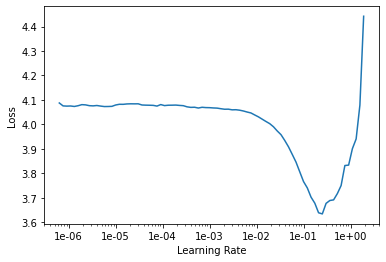

In [49]:
cls2.recorder.plot()

In [50]:
cls2.fit_one_cycle(3, 1e-1, moms=(0.8,0.7))
#cls2.save('dbpedia_type_fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,2.123792,2.082549,0.431662,00:03
1,1.978827,1.962936,0.435884,00:03
2,1.955532,1.933031,0.435884,00:03


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [51]:
#cls2.load('dbpedia_type_fit_head')
cls2.unfreeze()
cls2.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.789489,1.729295,0.536148,00:08
1,1.510096,1.671385,0.572032,00:08
2,1.313699,2.162984,0.621108,00:09
3,1.160125,1.276337,0.679683,00:08
4,0.999000,1.161136,0.707652,00:09
5,0.918735,2.541431,0.720317,00:08
6,0.821879,1.135240,0.731398,00:09
7,0.724172,1.088920,0.746702,00:09
8,0.666378,1.075950,0.739842,00:09
9,0.646035,1.074619,0.742480,00:09


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
#cls2.save('dbpedia_type_fit_c5')

In [53]:
#cls2.load('dbpedia_type_fit_c5')
cls2.unfreeze()
cls2.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.649252,1.085979,0.744591,00:09
1,0.644415,1.206892,0.744063,00:09
2,0.632785,1.611266,0.747757,00:09
3,0.627514,1.097677,0.754617,00:09
4,0.607484,1.170343,0.755673,00:09


In [ ]:
#cls2.save_encoder('/content/drive/My Drive/fastai-v3/model/smarttask/dbpedia_resource_type_fit_c15')

In [54]:
cls2.show_results(ds_type=DatasetType.Valid)

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target,prediction
xxbos xxmaj which family member of xxmaj xxunk xxmaj xxunk is a writer by profession ? \n \n xxmaj name the family member of xxmaj xxunk xxmaj xxunk who is a writer by profession . \n \n xxmaj which of xxmaj xxunk xxmaj xxunk 's relatives has a career in writing ? \n \n xxmaj who is the relative of xxmaj xxunk xxmaj xxunk who has a,dbo:Agent,dbo:Agent
"xxbos xxmaj what is the xxunk with the safety classification and labelling of xxup nfpa 704 : xxmaj standard xxmaj system for the xxmaj identification of the xxmaj hazards of xxmaj materials for xxmaj emergency xxmaj response and which has the word "" xxunk "" in its name ?",dbo:ChemicalSubstance,dbo:ChemicalSubstance
"xxbos xxmaj he was xxunk and had xxunk for xxunk years . xxmaj xxunk xxmaj xxunk xxup iv was buried on xxunk xxmaj xxunk xxunk at xxmaj xxunk xxmaj xxunk ( the xxmaj royal cemetery ) in the xxmaj xxunk capital , xxmaj xxunk .",dbo:Location,dbo:Location
xxbos xxmaj what is the { excipient with the lowest xxunk viscosity whose safety classification and labelling is xxup nfpa 704 : xxmaj standard xxmaj system for the xxmaj identification of the xxmaj hazards of xxmaj materials for xxmaj emergency xxmaj response ?,dbo:ChemicalSubstance,dbo:ChemicalSubstance
"xxbos "" xxmaj who is { born at } of { xxmaj leopold i , xxmaj holy xxmaj roman xxmaj emperor } , where { county seat for } is { xxmaj austria - xxmaj hungary } ? """,dbo:Location,dbo:Location


In [55]:
test_res_df = test_df[test_df.category == 'resource']
data_cls.add_test(test_res_df)

In [56]:
type_preds, *_  = cls2.get_preds(DatasetType.Test)
type_labels = np.argmax(type_preds, 1)

In [57]:
type_labels = type_labels.numpy()

In [58]:
type_labels

array([ 1,  1,  1, 20, ...,  0,  0,  1,  0])

In [71]:
!pip install pycm

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 573kB 5.7MB/s 


In [72]:
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
len(type_labels)

2445

In [60]:
test_res_df['type_pred'] = type_labels
test_res_df.type_pred= test_res_df.type_pred.replace({ i:c for i,c in enumerate(types)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
test_res_df.head()

,id,question,category,type,frequent_type,bottom_level_type,top_level_type,type_pred
6,dbpedia_22599,Where did the war take place where one of the ...,resource,"[dbo:Country, dbo:PopulatedPlace, dbo:Place]",dbo:Country,dbo:Country,dbo:Place,dbo:Location
9,dbpedia_19677,Which mountains are contained in Inyo National...,resource,"[dbo:Mountain, dbo:NaturalPlace, dbo:Place]",dbo:NaturalPlace,dbo:Mountain,dbo:Place,dbo:Location
11,dbpedia_11163,What is the seat of Frankfurter Allgemeine Zei...,resource,"[dbo:City, dbo:Settlement, dbo:PopulatedPlace,...",dbo:Settlement,dbo:City,dbo:Place,dbo:Location
16,dbpedia_18792,What did the people buried in Toronto die of?,resource,[dbo:Disease],dbo:Disease,dbo:Disease,dbo:Disease,dbo:Disease
19,dbpedia_11251,What is the league of major league lacrosse?,resource,"[dbo:SportsTeam, dbo:Organisation, dbo:Agent]",dbo:SportsTeam,dbo:SportsTeam,dbo:Agent,dbo:Agent


In [63]:
from sklearn.metrics import accuracy_score

In [64]:
accuracy_score(test_res_df[target], test_res_df.type_pred, normalize=True)

0.5905930470347648

In [93]:
cm = ConfusionMatrix(test_df.top_level_type.to_list(), test_df.type_pred.to_list())

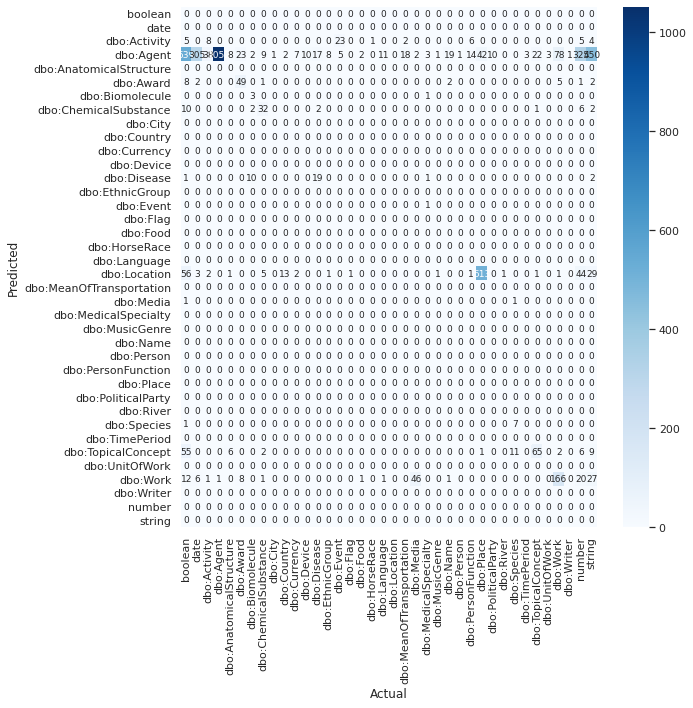

In [94]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10,10))
ax= sns.heatmap(pd.DataFrame(cm.table), annot=True, annot_kws={"size": 9}, fmt='d', cmap="Blues")
#plt.xlabel('Experts'); plt.ylabel('Workers');
ax.set_xlabel('Actual');ax.set_ylabel('Predicted'); 
plt.tight_layout()
plt.show()
#ax.get_figure().savefig('worker_vs_expert.png', dpi=200)